# Introduction
## Which mortgage strategy should we choose?

This notebook will be used to evaluate the cumulative costs of several mortgage scenarios.

We will consider the cumulative costs with regards to:
- fixed vs variable interest rates
- variable spread percentages
- total loan amounts


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import numpy_financial as npf

In [2]:
import paymentFunctions as pay

# Euribor Interest Rates

This section explores the historical euribor interest rates from 2000-2024.

- Import interest rates from excel spreadsheet
- Clean and prepare for analysis
- Summarize data
- Plot them over time

## Data source

All data downloaded from https://www.suomenpankki.fi/ and stored locally.

In [3]:
euribor_1 = pd.read_excel('euribor-rates/euribor_2000-2022.xlsx', skiprows=4, skipfooter=3)
euribor_2 = pd.read_excel('euribor-rates/euribor_2008-2024.xlsx', skiprows=4, skipfooter=3)

## Data cleaning
The next steps are to combine the two sets and remove any duplicated dates.

In [4]:
euribor_rates = pd.concat([euribor_1, euribor_2]).reset_index(drop=True)

In [5]:
euribor_rates.duplicated();

In [6]:
euribor_rates_final = euribor_rates.drop_duplicates()

In [7]:
euribor_rates_final = euribor_rates_final.astype({"Period": "datetime64[s]"})

C:\Users\kiesw\AppData\Local\Temp\ipykernel_32092\1371155062.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  euribor_rates_final = euribor_rates_final.astype({"Period": "datetime64[s]"})


In [8]:
euribor_rates_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 289 entries, 0 to 288
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype        
---  ------              --------------  -----        
 0   Period              289 non-null    datetime64[s]
 1   Eonia (act/360)     264 non-null    float64      
 2   1 month (act/360)   289 non-null    float64      
 3   3 month (act/360)   289 non-null    float64      
 4   6 month (act/360)   289 non-null    float64      
 5   12 month (act/360)  289 non-null    float64      
dtypes: datetime64[s](1), float64(5)
memory usage: 15.8 KB


In [9]:
euribor_rates_final = euribor_rates_final.sort_values(by=["Period"]).reset_index(drop=True)

In [11]:
euribor_rates_final.describe()

,Period,Eonia (act/360),1 month (act/360),3 month (act/360),6 month (act/360),12 month (act/360)
count,289,264.000000,289.000000,289.000000,289.000000,289.000000
mean,2011-12-31 16:16:36,1.308309,1.412064,1.530437,1.641678,1.792062
min,2000-01-01 00:00:00,-0.492217,-0.596261,-0.583000,-0.544609,-0.504429
25%,2006-01-01 00:00:00,-0.337857,-0.355909,-0.254050,-0.143050,-0.009762
50%,2012-01-01 00:00:00,0.402818,0.792810,1.021652,1.269045,1.549952
75%,2018-01-01 00:00:00,2.776077,2.992857,3.179444,3.262455,3.369391
max,2024-01-01 00:00:00,5.064211,4.943476,5.113087,5.218955,5.393217
std,NaN,1.724486,1.775986,1.796133,1.787519,1.783634


## Plot

In [12]:
plt.style.use("default")
plt.rcParams.update({'font.size': 12})

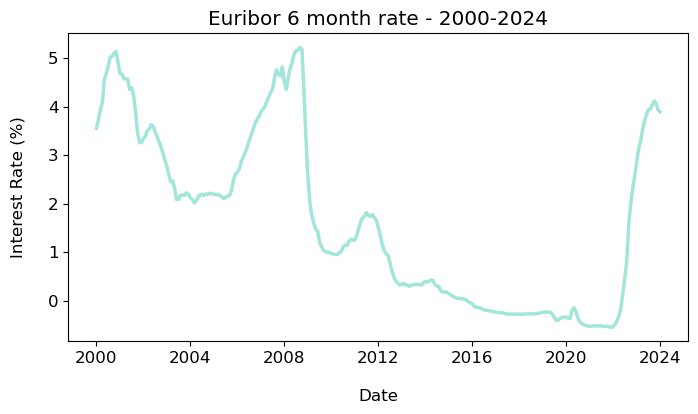

In [13]:
plt.figure(figsize=(8, 4))

plt.plot(euribor_rates_final['Period'], euribor_rates_final['6 month (act/360)'],
         color='#A2E5D9',
         linewidth=2.5)


plt.title("Euribor 6 month rate - 2000-2024")
plt.xlabel("\nDate")
plt.ylabel("Interest Rate (%)\n")

plt.show()

# Amortization table

Using the PMT function from the Numpy-Financial package we can calculate and display every mortgage payment in a given simulation.

npf.pmt(rate, periods, pv, fv)

The given variables are:

- interest_rate = the annual interest rate
- periods = the number of payment periods (months x years)
- present value (pv) = the amount borrowed
- future value (fv) = zero

In [14]:
# given variables for example
interest_rate = 3.85 / 100
payments = 12
years = 30
pv = 172500
fv = 0

In [15]:
# set up initial dataframe

payment_number = range(1, (payments * years) + 1) 

schedule = pd.DataFrame(index=payment_number, 
                        columns = ["payment_num",
                                   "payment",
                                   "principle",
                                   "interest",
                                   "balance"])

schedule.head()

,payment_num,payment,principle,interest,balance
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN


In [16]:
# populate the dataframe
schedule["payment_num"] = payment_number
schedule["payment"] = abs(npf.pmt(interest_rate/payments, years * payments, pv, fv))
schedule["principle"] = abs(npf.ppmt(interest_rate/payments, schedule.index, years * payments, pv))
schedule["interest"] = abs(npf.ipmt(interest_rate/payments, schedule.index, years * payments, pv))

In [17]:
#calculate the cumulative amounts
schedule['cumlative_payment'] = schedule['payment'].cumsum()
schedule['cumlative_interest'] = schedule['interest'].cumsum()
schedule['cumlative_principle'] = schedule['principle'].cumsum()
schedule['balance'] = pv - schedule['cumlative_principle']

In [18]:
schedule = round(schedule, 2)
schedule

,payment_num,payment,principle,interest,balance,cumlative_payment,cumlative_interest,cumlative_principle
1,1,808.69,255.26,553.44,172244.74,808.69,553.44,255.26
2,2,808.69,256.08,552.62,171988.67,1617.39,1106.06,511.33
3,3,808.69,256.90,551.80,171731.77,2426.08,1657.85,768.23
4,4,808.69,257.72,550.97,171474.05,3234.78,2208.83,1025.95
5,5,808.69,258.55,550.15,171215.50,4043.47,2758.97,1284.50
...,...,...,...,...,...,...,...,...
356,356,808.69,795.85,12.85,3209.00,287895.14,118604.13,169291.00
357,357,808.69,798.40,10.30,2410.60,288703.83,118614.43,170089.40
358,358,808.69,800.96,7.73,1609.64,289512.52,118622.16,170890.36
359,359,808.69,803.53,5.16,806.11,290321.22,118627.33,171693.89


# Fixed mortgage function

Fixed mortages have the same interest rate for the duration of the loan.

The example above was a fixed rate mortgage, but we can combine the above code into a single function.

This function is defined as <b>amortize_fixed</b> in <b>paymentFunctions.py</b>

In [20]:
pay.amortize_fixed(2.85, 30, 172500, 0)

# it works!

,payment_num,rate,payment,principle,interest,balance,cumlative_payment,cumlative_interest,cumlative_principle,type,simulation
1,1,2.85,713.39,303.70,409.69,172196.30,713.39,409.69,303.70,fixed,1
2,2,2.85,713.39,304.42,408.97,171891.88,1426.77,818.65,608.12,fixed,1
3,3,2.85,713.39,305.14,408.24,171586.74,2140.16,1226.90,913.26,fixed,1
4,4,2.85,713.39,305.87,407.52,171280.87,2853.55,1634.42,1219.13,fixed,1
5,5,2.85,713.39,306.59,406.79,170974.28,3566.93,2041.21,1525.72,fixed,1
...,...,...,...,...,...,...,...,...,...,...,...
356,356,2.85,713.39,704.98,8.41,2836.68,253965.59,84302.27,169663.32,fixed,1
357,357,2.85,713.39,706.65,6.74,2130.03,254678.98,84309.01,170369.97,fixed,1
358,358,2.85,713.39,708.33,5.06,1421.71,255392.36,84314.07,171078.29,fixed,1
359,359,2.85,713.39,710.01,3.38,711.70,256105.75,84317.45,171788.30,fixed,1


# Variable mortgage

Variable mortgages are a bit trickier to deal with as the interest rate fluctuates for the duration of the loan.<br><br>
This calculator uses historical interest rates to run mortgage simulations. 

We will use the six-month Euribor rates from 2000 - 2024 to compare a fixed vs variable mortgage over that 24 year period.<br>
The six-month rate is used because that closely resembles our real-life situation.

Some additional variables to consider include:
- spread = the bank profit interest rate

The function is called <b>amortize_variable</b> in the <b>paymentFunction.py</b> script.

### Getting variable rates - Euribor rates

We first need to rework the interest rates to reflect a real-world scenario. <br>
In our case the interest rate will be renewed every six months.

To emulate this we took the rate at six month intervals and duplicated them between each interval.

In [21]:
euribor_6month = euribor_rates_final[["Period", "6 month (act/360)"]].rename(columns={"6 month (act/360)": "6-month"});
variable_rates = euribor_6month
variable_rates = variable_rates.iloc[::6, :]
variable_rates = variable_rates.loc[np.repeat(variable_rates.index.values, 6)]
variable_rates = variable_rates.iloc[np.repeat(variable_rates.index.values, 1)]
variable_rates = variable_rates.tail(289)
variable_rates.reset_index(drop=True, inplace=True)

In [22]:
variable_rates.sample(3)

,Period,6-month
266,2022-07-01,0.466476
34,2003-01-01,2.758136
44,2004-01-01,2.115429


### Saving variable rates as excel for future use


In [41]:
filename = "euribor-rates/euribor_variable.xlsx"
variable_rates.to_excel(filename, index=False)

## Variable mortgage function


In [24]:
pay.amortize_variable(variable_rates, "6-month", 0.9, 24, 152500, 0).tail(1)

# it works!

,payment_num,euribor,spread,rate,payments remaining,starting balance,payment,interest,principle,end balance,cumlative_payment,cumlative_principle,cumlative_interest,balance,type,simulation
288,288,3.89,0.9,4.79,1,693.58,696.35,2.77,693.58,-0.0,216448.69,152500.0,63948.69,0.0,variable spread: 0.9%,1


## Bonus: Randomly select variable interest rates

The previous simulation is a real-time evaluation of 24 years.<br> 
If we want to simulation variable rates for longer periods we need a work-around.

The below code randomly samples the euribor data for rates and prepares it for use in the amortize_variable function.

In [26]:
years = 30
samples = int((years * 12) / 6)

In [27]:
variable_rates_random = euribor_6month.sample(samples).reset_index()
variable_rates_random.head()

,index,Period,6-month
0,163,2013-08-01,0.342227
1,240,2020-01-01,-0.330091
2,111,2009-04-01,1.608300
3,230,2019-03-01,-0.230238
4,96,2008-01-01,4.501364


In [28]:
variable_rates_random = variable_rates_random.iloc[np.repeat(variable_rates_random.index.values, 6)]
variable_rates_random.reset_index(drop=True, inplace=True)
variable_rates_random.index = variable_rates_random.index + 1
variable_rates_random.tail()

,index,Period,6-month
356,139,2011-08-01,1.754783
357,139,2011-08-01,1.754783
358,139,2011-08-01,1.754783
359,139,2011-08-01,1.754783
360,139,2011-08-01,1.754783


In [30]:
pay.amortize_variable(variable_rates_random, "6-month", 0.9, 30, 152500, 0, "random")

,payment_num,euribor,spread,rate,payments remaining,starting balance,payment,interest,principle,end balance,cumlative_payment,cumlative_principle,cumlative_interest,balance,type,simulation
1,1,0.34,0.9,1.24,360,152500.00,507.65,157.87,349.79,152150.21,507.65,349.79,157.87,152150.21,variable spread: 0.9%,random
2,2,0.34,0.9,1.24,359,152150.21,507.49,157.22,350.27,151799.94,1015.14,700.06,315.09,151799.94,variable spread: 0.9%,random
3,3,0.34,0.9,1.24,358,151799.94,507.49,156.86,350.63,151449.31,1522.64,1050.69,471.95,151449.31,variable spread: 0.9%,random
4,4,0.34,0.9,1.24,357,151449.31,507.49,156.50,351.00,151098.31,2030.13,1401.69,628.45,151098.31,variable spread: 0.9%,random
5,5,0.34,0.9,1.24,356,151098.31,507.49,156.13,351.36,150746.95,2537.62,1753.05,784.58,150746.95,variable spread: 0.9%,random
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,356,1.75,0.9,2.65,5,3032.96,610.62,6.70,603.92,2429.04,218530.90,150070.96,68459.96,2429.04,variable spread: 0.9%,random
357,357,1.75,0.9,2.65,4,2429.04,610.62,5.36,605.25,1823.79,219141.52,150676.21,68465.32,1823.79,variable spread: 0.9%,random
358,358,1.75,0.9,2.65,3,1823.79,610.62,4.03,606.59,1217.20,219752.14,151282.80,68469.35,1217.20,variable spread: 0.9%,random
359,359,1.75,0.9,2.65,2,1217.20,610.62,2.69,607.93,609.27,220362.75,151890.73,68472.04,609.27,variable spread: 0.9%,random


## Plotting comparisons


### Fixed vs variable

In [ ]:
simulations_interest = simulations.pivot_table(index="payment_num",
                                              columns="simulation",
                                              values="cumlative_interest")
simulations_interest.tail(3)

In [ ]:
plt.style.use("default")

fig1 = simulations_interest.plot(figsize = (8,6),
                                 linewidth=2.5,
                                 xlabel = "\nPayment",
                                 ylabel = "Amount (Eur)\n",
                                 title = "Interest paid",
                                 legend = True);

fig1.text(x = 310, y = simulations_interest["sim1"].max(), s = 'Sim 1: $152,000, variable + 0.9%', fontsize = 12)
fig1.text(x = 310, y = simulations_interest["sim2"].max(), s = 'Sim 2: $172,000, variable + 0.9%', fontsize = 12)
fig1.text(x = 310, y = simulations_interest["sim3"].max() - 2000, s = 'Sim 3: $152,000, variable + 0.8%', fontsize = 12)
fig1.text(x = 310, y = simulations_interest["sim4"].max() - 2000, s = 'Sim 4: $172,000, variable + 0.8%', fontsize = 12)
fig1.text(x = 310, y = simulations_interest["sim5"].max(), s = 'Sim 5: $172,000, fixed', fontsize = 12)
fig1.text(x = 310, y = simulations_interest["sim6"].max(), s = 'Sim 6: $152,000, fixed', fontsize = 12);


### Spread contribution


In [ ]:
simulations_interest_spread = simulations_interest[['sim1', 'sim2','sim3', 'sim4']]

In [ ]:
plt.style.use("default")

fig2 =simulations_interest_spread.plot(figsize = (8,6),
                                 linewidth=2.5,
                                 xlabel = "\nPayment",
                                 ylabel = "Amount (Eur)\n",
                                 title = "Interest paid",
                                 legend = True);

fig2.text(x = 310, y = simulations_interest_spread["sim1"].max(), s = 'Sim 1: $152,000, variable + 0.9%', fontsize = 12)
fig2.text(x = 310, y = simulations_interest_spread["sim2"].max(), s = 'Sim 2: $172,000, variable + 0.9%', fontsize = 12)
fig2.text(x = 310, y = simulations_interest_spread["sim3"].max() - 1000, s = 'Sim 3: $152,000, variable + 0.8%', fontsize = 12)
fig2.text(x = 310, y = simulations_interest_spread["sim4"].max() - 1000, s = 'Sim 4: $172,000, variable + 0.8%', fontsize = 12)

In [ ]:
spread_savings24 = round((simulations_interest['sim2'].max() - simulations_interest['sim4'].max()),2)
spread_savings13 = round((simulations_interest['sim1'].max() - simulations_interest['sim3'].max()),2)

print(f'${spread_savings24} difference between simulation 2 and 4')
print(f'${spread_savings13} difference between simulation 1 and 3')

### Higher deposit

In [ ]:
simulations_interest_deposit = simulations_interest[['sim2', 'sim3','sim5', 'sim6']]

In [ ]:
plt.style.use("default")

fig3 = simulations_interest_deposit.plot(figsize = (8,6),
                                 linewidth=2.5,
                                 xlabel = "\nPayment",
                                 ylabel = "Amount (Eur)\n",
                                 title = "Interest paid",
                                 legend = True);

fig3.text(x = 310, y = simulations_interest_deposit["sim2"].max(), s = 'Sim 2: $172,000, variable + 0.9%', fontsize = 12)
fig3.text(x = 310, y = simulations_interest_deposit["sim3"].max() - 1000, s = 'Sim 3: $152,000, variable + 0.8%', fontsize = 12)
fig3.text(x = 310, y = simulations_interest_deposit["sim5"].max(), s = 'Sim 5: $172,000, fixed', fontsize = 12)
fig3.text(x = 310, y = simulations_interest_deposit["sim6"].max(), s = 'Sim 6: $152,000, fixed', fontsize = 12);

In [ ]:
deposit_savings23 = round((simulations_interest['sim2'].max() - simulations_interest['sim3'].max()),2)
deposit_savings56 = round((simulations_interest['sim5'].max() - simulations_interest['sim6'].max()),2)

print(f'${deposit_savings23} difference between simulation 2 and 3')
print(f'${deposit_savings56} difference between simulation 5 and 6')

## Simulation Summary

### Summary function

An additional function was created to summarize the amortization tables

In [ ]:
def mortgage_summary(amortization):
    df = amortization

    summary = {"Simulation": [df["simulation"].max()],
               "payments": [df["payment_num"].max()],
               "Years": [int(df.index.value_counts().sum()/12)],
               "Median interest rate": [df["rate"].median()],
               "Average payment": [df["payment"].mean()],
               "Min payment": [df["payment"].min()],
               "Max payment": [df["payment"].max()],
               "Principal": [df["cumlative_principle"].max()],
               "Interest": [df["cumlative_interest"].max()],
               "Payments": [df["cumlative_payment"].max()],
               "Type": [df["type"].max()]
              }
    if summary["Type"] == "variable":
        print("woo")
    else:
        None
    
    summary = pd.DataFrame(summary)
    summary= summary.round(2)

    return summary

In [ ]:
summary_comparison = pd.concat([mortgage_summary(sim1), 
                                mortgage_summary(sim2), 
                                mortgage_summary(sim3), 
                                mortgage_summary(sim4), 
                                mortgage_summary(sim5), 
                                mortgage_summary(sim6)]).reset_index(drop=True)

### Summary table

In [ ]:
summary_comparison = summary_comparison.sort_values(by=['Interest']).reset_index()
summary_comparison

In [ ]:
mortgage_summary(sim3)

In [35]:
fix1 = pay.amortize_fixed(2.85, 30, 175000, fv, name="30 year fixed")
fix1.tail()

,payment_num,rate,payment,principle,interest,balance,cumlative_payment,cumlative_interest,cumlative_principle,type,simulation
356,356,2.85,723.73,715.19,8.53,2877.79,257646.25,85524.05,172122.21,fixed,30 year fixed
357,357,2.85,723.73,716.89,6.83,2160.90,258369.98,85530.88,172839.10,fixed,30 year fixed
358,358,2.85,723.73,718.59,5.13,1442.31,259093.70,85536.01,173557.69,fixed,30 year fixed
359,359,2.85,723.73,720.30,3.43,722.01,259817.43,85539.44,174277.99,fixed,30 year fixed
360,360,2.85,723.73,722.01,1.71,0.00,260541.15,85541.15,175000.00,fixed,30 year fixed


# Single simulation plot

In [36]:
def mortgage_plot(amoritization):
    data = amoritization
    
    plt.style.use("default")
    plt.plot(data['payment_num'], data['cumlative_payment'], color='#83E28E',label = "payments", linewidth=2.5)
    plt.plot(data['payment_num'], data['cumlative_interest'], color='salmon',label = "interest", linewidth=2.5)
    plt.plot(data['payment_num'], data['cumlative_principle'],color='#A6C9EC',label = "principle", linewidth=2.5)
    plt.legend()
    plt.xlabel("Period")
    plt.ylabel("Outstanding Balance (Eur)")
    
    plt.title(str(int(data['payment_num'].max()/12)) + " year " + data['type'].max() + " €" + str(int(data['cumlative_principle'].max())))
    
    plt.show()

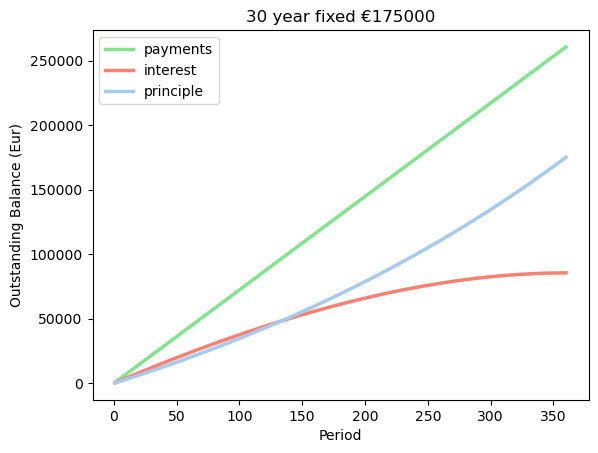

In [37]:
mortgage_plot(fix1)